In [1]:
# Load convolve_im_freq from freq_1.ipynb 
from IPython.display import clear_output
%run -n freq_1.ipynb 
clear_output(wait=False) 

import os
import numpy as np
import utils
import matplotlib.pyplot as plt 

In [ ]:
def create_kernel(im):
    """
    Creates a filter kernel in the frequency domain.

    Args:
        im: np.array of shape [H, W]
    Returns:
        kernel: np.array of shape [H, W]
    """

    H, W = im.shape
    cy, cx = H // 2, W // 2

    F = np.fft.fft2(im.astype(np.float32, copy=False))
    F_shift = np.fft.fftshift(F)
    mag = np.abs(F_shift)

    mag_no_dc = mag.copy()
    yy, xx = np.ogrid[:H, :W]
    dc_radius = 12
    dc_region = (yy - cy)**2 + (xx - cx)**2 <= dc_radius**2
    mag_no_dc[dc_region] = 0.0

    flat_sorted_idx = np.argsort(mag_no_dc.ravel())[::-1]
    candidate_coords = []
    for idx in flat_sorted_idx[:200]:
        y = idx // W
        x = idx % W

        if abs(x - cx) < 5 and abs(y - cy) < 5:
            continue

        too_close = False
        for (py, px) in candidate_coords:
            if (abs(py - y) < 4) and (abs(px - x) < 4):
                too_close = True
                break
        if too_close:
            continue

        candidate_coords.append((y, x))

        if len(candidate_coords) >= 4:
            break

    notch_mask_shift = np.ones((H, W), dtype=np.float32)

    notch_halfsize = 2

    def zero_square(mask, cy_local, cx_local, half):
        y0 = max(cy_local - half, 0)
        y1 = min(cy_local + half + 1, H)
        x0 = max(cx_local - half, 0)
        x1 = min(cx_local + half + 1, W)
        mask[y0:y1, x0:x1] = 0.0

    used = []
    for (py, px) in candidate_coords:
        already = False
        for (uy, ux) in used:
            if (abs(uy - py) < 4) and (abs(ux - px) < 4):
                already = True
                break
        if already:
            continue

        zero_square(notch_mask_shift, py, px, notch_halfsize)

        sym_y = (2 * cy) - py
        sym_x = (2 * cx) - px
        if 0 <= sym_y < H and 0 <= sym_x < W:
            zero_square(notch_mask_shift, sym_y, sym_x, notch_halfsize)

        used.append((py, px))
        used.append((sym_y, sym_x))

    notch_mask = np.fft.ifftshift(notch_mask_shift)

    return notch_mask

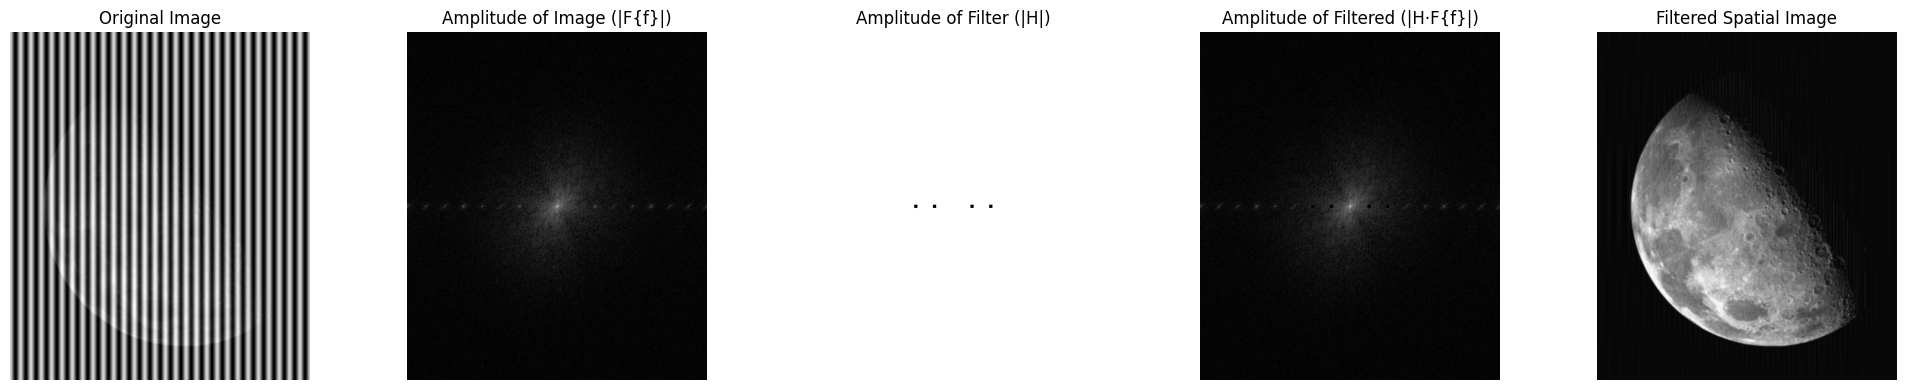

Saving image to: image_processed/moon_filtered.png


In [6]:
if __name__ == "__main__":
    # Changing this code should not be needed!
    
    impath = os.path.join("images", "noisy_moon.png")
    im = utils.read_im(impath)

    kernel = create_kernel(im)        
    # Note that this function is from your own implementation of convolve_im_freq from freq_1.ipynb
    im_filtered = convolve_im_freq(im, kernel, True) 
    
    utils.save_im("moon_filtered.png", utils.normalize(im_filtered))